# Лабораторная работа №1 - Исследование KNN (классификация + регрессия)

**Цель:** провести исследование алгоритма *k ближайших соседей (KNN)* на двух реальных прикладных задачах:
1) выбрать датасеты и метрики качества
2) построить бейзлайн
3) улучшить бейзлайн
4) реализовать KNN самостоятельно и сравнить качество

**Выбранные наборы данных (Kaggle):**
- **Классификация:** *Faulty Steel Plates* - определение типа дефекта стального листа по измеренным признакам.
- **Регрессия:** *Concrete Compressive Strength* - прогноз прочности бетона по составу смеси и возрасту образца.


In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:


from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

def _read_first_csv(folder: Path) -> pd.DataFrame:
    csv_files = list(folder.rglob("*.csv"))
    if not csv_files:
        raise FileNotFoundError(f"В папке {folder} не найдено ни одного .csv файла")
    csv_files.sort(key=lambda p: p.stat().st_size, reverse=True)
    return pd.read_csv(csv_files[0])

def _download_kaggle_dataset(handle: str) -> Path:
    import kagglehub
    path = kagglehub.dataset_download(handle)
    return Path(path)

def load_classification_dataset() -> tuple[pd.DataFrame, pd.Series]:
    handle = "uciml/faulty-steel-plates"
    try:
        folder = _download_kaggle_dataset(handle)
        df = _read_first_csv(folder)
    except Exception as e:
        df = _read_first_csv(DATA_DIR)

    fault_cols = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]
    present_fault_cols = [c for c in fault_cols if c in df.columns]

    if len(present_fault_cols) >= 2:
        y = df[present_fault_cols].idxmax(axis=1)
        X = df.drop(columns=present_fault_cols)
    else:
        target_candidates = [c for c in df.columns if c.lower() in {"class", "target", "label", "fault"}]
        target_col = target_candidates[0] if target_candidates else df.columns[-1]
        y = df[target_col].astype(str)
        X = df.drop(columns=[target_col])

    return X, y

def load_regression_dataset() -> tuple[pd.DataFrame, pd.Series]:
    handle = "elikplim/concrete-compressive-strength-data-set"
    try:
        folder = _download_kaggle_dataset(handle)
        df = _read_first_csv(folder)
    except Exception as e:
        df = _read_first_csv(DATA_DIR)

    strength_candidates = [c for c in df.columns if ("strength" in c.lower()) or ("mpa" in c.lower())]
    target_col = strength_candidates[0] if strength_candidates else df.columns[-1]

    y = df[target_col].astype(float)
    X = df.drop(columns=[target_col])

    return X, y


X_cls, y_cls = load_classification_dataset()
X_reg, y_reg = load_regression_dataset()

print("Итог:")
print("  Классификация: X =", X_cls.shape, ", y =", y_cls.shape, ", классов =", y_cls.nunique())
print("  Регрессия:     X =", X_reg.shape, ", y =", y_reg.shape)


C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Итог:
  Классификация: X = (1941, 27) , y = (1941,) , классов = 7
  Регрессия:     X = (1030, 8) , y = (1030,)


Пропуски (признаки классификации): 0
Пропуски (признаки регрессии): 0

Распределение классов (топ-10):
Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
Name: count, dtype: int64


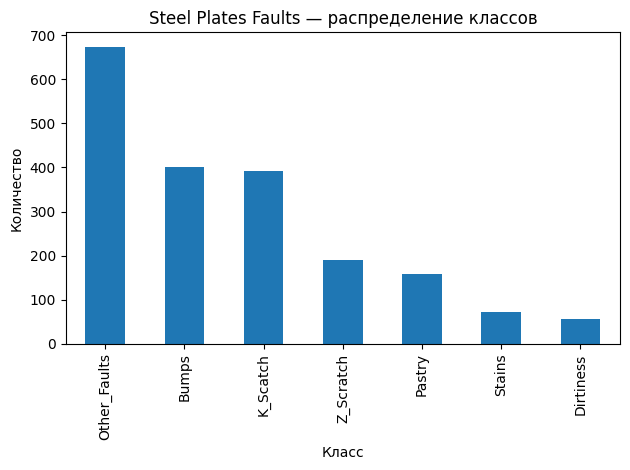


Целевая переменная - сводная статистика:
count    1030.000000
mean       35.817961
std        16.705742
min         2.330000
25%        23.710000
50%        34.445000
75%        46.135000
max        82.600000
Name: concrete_compressive_strength, dtype: float64


In [3]:
print("Пропуски (признаки классификации):", int(X_cls.isna().sum().sum()))
print("Пропуски (признаки регрессии):", int(X_reg.isna().sum().sum()))


cls_counts = y_cls.value_counts()
print("\nРаспределение классов (топ-10):")
print(cls_counts.head(10))

plt.figure()
cls_counts.plot(kind="bar")
plt.title("Steel Plates Faults — распределение классов")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

print("\nЦелевая переменная - сводная статистика:")
print(y_reg.describe())

## 1) Выбор метрик качества

### Классификация
- **Accuracy** - доля верных ответов.
- **Macro F1** - средний F1 по классам *без учёта дисбаланса*, поэтому хорошо подходит, когда классы могут встречаться с разной частотой.

### Регрессия
- **MAE (Mean Absolute Error)** - средняя абсолютная ошибка.
- **RMSE (Root Mean Squared Error)** - сильнее штрафует большие ошибки.
- **R²** - доля объяснённой дисперсии.


In [4]:


Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_cls 
)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("  Классификация  train/test:", Xc_train.shape, Xc_test.shape)
print("  Регрессия  train/test:", Xr_train.shape, Xr_test.shape)

  Классификация  train/test: (1552, 27) (389, 27)
  Регрессия  train/test: (824, 8) (206, 8)


In [5]:
knn_cls_base = KNeighborsClassifier(n_neighbors=5)
knn_cls_base.fit(Xc_train, yc_train)
yc_pred_base = knn_cls_base.predict(Xc_test)

acc_base = accuracy_score(yc_test, yc_pred_base)
f1m_base = f1_score(yc_test, yc_pred_base, average="macro")

print("Базовый KNN (классификация)")
print("  Accuracy :", round(acc_base, 4))
print("  Macro F1 :", round(f1m_base, 4))
print("\nОтчет по классификации:")
print(classification_report(yc_test, yc_pred_base))

Базовый KNN (классификация)
  Accuracy : 0.4499
  Macro F1 : 0.309

Отчет по классификации:
              precision    recall  f1-score   support

       Bumps       0.34      0.53      0.41        81
   Dirtiness       0.57      0.36      0.44        11
    K_Scatch       0.86      0.76      0.80        78
Other_Faults       0.43      0.50      0.46       135
      Pastry       0.00      0.00      0.00        32
      Stains       0.00      0.00      0.00        14
   Z_Scratch       0.08      0.03      0.04        38

    accuracy                           0.45       389
   macro avg       0.33      0.31      0.31       389
weighted avg       0.42      0.45      0.42       389



In [7]:
knn_reg_base = KNeighborsRegressor(n_neighbors=5)
knn_reg_base.fit(Xr_train, yr_train)
yr_pred_base = knn_reg_base.predict(Xr_test)

mae_base = mean_absolute_error(yr_test, yr_pred_base)
rmse_base = np.sqrt(mean_squared_error(yr_test, yr_pred_base))
r2_base = r2_score(yr_test, yr_pred_base)

print("Базовый KNN (регрессия)")
print("  MAE  :", round(mae_base, 4))
print("  RMSE :", round(rmse_base, 4))
print("  R2   :", round(r2_base, 4))

Базовый KNN (регрессия)
  MAE  : 6.4423
  RMSE : 8.2318
  R2   : 0.737


## 3) Улучшение бейзлайна

Для KNN критично, чтобы признаки были в одном масштабе, поэтому основной шаг - **стандартизация **.

Далее проверяем гипотезу:
- подбор `n_neighbors`, `weights`, а также метрики расстояния через `p`  с помощью  кросс‑валидации.


In [8]:
pipe_cls = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

param_grid_cls = {
    "knn__n_neighbors": list(range(1, 31, 2)),  
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]
}

grid_cls = GridSearchCV(
    pipe_cls,
    param_grid=param_grid_cls,
    cv=5,
    n_jobs=-1,
    scoring="f1_macro"  
)

grid_cls.fit(Xc_train, yc_train)

print("Лучшие параметры CV (классификация):", grid_cls.best_params_)
print("Лучший макро F1 CV:", round(grid_cls.best_score_, 4))

yc_pred_impr = grid_cls.predict(Xc_test)
acc_impr = accuracy_score(yc_test, yc_pred_impr)
f1m_impr = f1_score(yc_test, yc_pred_impr, average="macro")

print("\nУлучшенный KNN на тестовой выборке")
print("  Accuracy :", round(acc_impr, 4))
print("  Macro F1 :", round(f1m_impr, 4))

Лучшие параметры CV (классификация): {'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}
Лучший макро F1 CV: 0.7745

Улучшенный KNN на тестовой выборке
  Accuracy : 0.7532
  Macro F1 : 0.7519


In [10]:
pipe_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])

param_grid_reg = {
    "knn__n_neighbors": list(range(1, 41, 2)),  
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]
}

grid_reg = GridSearchCV(
    pipe_reg,
    param_grid=param_grid_reg,
    cv=5,
    n_jobs=-1,
    scoring="neg_mean_absolute_error"
)

grid_reg.fit(Xr_train, yr_train)

print("Лучшие параметры CV (регрессия):", grid_reg.best_params_)
print("Лучший MAE CV (приблизительно):", round(-grid_reg.best_score_, 4))

yr_pred_impr = grid_reg.predict(Xr_test)
mae_impr = mean_absolute_error(yr_test, yr_pred_impr)
rmse_impr = np.sqrt(mean_squared_error(yr_test, yr_pred_impr))
r2_impr = r2_score(yr_test, yr_pred_impr)

print("\nУлучшенный KNN (регрессия) на тестовой выборке")
print("  MAE  :", round(mae_impr, 4))
print("  RMSE :", round(rmse_impr, 4))
print("  R2   :", round(r2_impr, 4))

Лучшие параметры CV (регрессия): {'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'distance'}
Лучший MAE CV (приблизительно): 6.0513

Улучшенный KNN (регрессия) на тестовой выборке
  MAE  : 5.6275
  RMSE : 7.5892
  R2   : 0.7765


In [11]:
print("Классификация")
print("Базовый:  acc =", round(acc_base, 4), "macro_f1 =", round(f1m_base, 4))
print("Улучшенный:  acc =", round(acc_impr, 4), "macro_f1 =", round(f1m_impr, 4))

print("\nРегрессия")
print("Базовый:  MAE =", round(mae_base, 4), "RMSE =", round(rmse_base, 4), "R2 =", round(r2_base, 4))
print("Улучшенный:  MAE =", round(mae_impr, 4), "RMSE =", round(rmse_impr, 4), "R2 =", round(r2_impr, 4))

Классификация
Базовый:  acc = 0.4499 macro_f1 = 0.309
Улучшенный:  acc = 0.7532 macro_f1 = 0.7519

Регрессия
Базовый:  MAE = 6.4423 RMSE = 8.2318 R2 = 0.737
Улучшенный:  MAE = 5.6275 RMSE = 7.5892 R2 = 0.7765


## 4) Реализация KNN

Реализуем:
- **KNN-классификатор**: голосование по k ближайшим соседям .
- **KNN-регрессор**: среднее/взвешенное среднее по значениям y ближайших соседей.

Далее сравниваем:
1) кастомную реализацию и sklearn на сыром бейзлайне,
2) кастомную реализацию с теми же улучшениями и улучшенный sklearn.


In [12]:

class MyKNNBase:
    def __init__(self, n_neighbors=5, weights="uniform", p=2, eps=1e-9):
        self.n_neighbors = int(n_neighbors)
        self.weights = weights
        self.p = p
        self.eps = eps  

    def fit(self, X, y):
        self.X_train_ = np.asarray(X, dtype=float)
        self.y_train_ = np.asarray(y)
        return self

    def _distances(self, X):
        X = np.asarray(X, dtype=float)

        diff = np.abs(X[:, None, :] - self.X_train_[None, :, :])

        d = np.sum(diff ** self.p, axis=2) ** (1.0 / self.p)
        return d

    def _knn_indices_and_distances(self, X):
        d = self._distances(X)
        idx = np.argpartition(d, kth=self.n_neighbors - 1, axis=1)[:, :self.n_neighbors]
        d_k = np.take_along_axis(d, idx, axis=1)
        return idx, d_k


class MyKNNClassifier(MyKNNBase):
    def fit(self, X, y):
        self.le_ = LabelEncoder()
        y_enc = self.le_.fit_transform(np.asarray(y))
        super().fit(X, y_enc)
        return self

    def predict(self, X):
        idx, d_k = self._knn_indices_and_distances(X)
        neigh_labels = self.y_train_[idx]  

        if self.weights == "uniform":
            preds = []
            for row in neigh_labels:
                counts = np.bincount(row)
                preds.append(np.argmax(counts))
            preds = np.array(preds, dtype=int)
        elif self.weights == "distance":
            w = 1.0 / (d_k + self.eps) 
            preds = []
            for labels_row, w_row in zip(neigh_labels, w):
                scores = np.bincount(labels_row, weights=w_row)
                preds.append(np.argmax(scores))
            preds = np.array(preds, dtype=int)
        else:
            raise ValueError("weights must be 'uniform' or 'distance'")

        return self.le_.inverse_transform(preds)


class MyKNNRegressor(MyKNNBase):
    def predict(self, X):
        idx, d_k = self._knn_indices_and_distances(X)
        neigh_values = self.y_train_[idx].astype(float)

        if self.weights == "uniform":
            return np.mean(neigh_values, axis=1)
        elif self.weights == "distance":
            w = 1.0 / (d_k + self.eps)  # (n_test, k)
            return np.sum(neigh_values * w, axis=1) / np.sum(w, axis=1)
        else:
            raise ValueError("weights must be 'uniform' or 'distance'")


In [13]:


my_cls_base = MyKNNClassifier(n_neighbors=5, weights="uniform", p=2)
my_cls_base.fit(Xc_train, yc_train)
yc_pred_my_base = my_cls_base.predict(Xc_test)

acc_my_base = accuracy_score(yc_test, yc_pred_my_base)
f1m_my_base = f1_score(yc_test, yc_pred_my_base, average="macro")

print("Кастомный KNN (классификация) базовый")
print("  Accuracy :", round(acc_my_base, 4))
print("  Macro F1 :", round(f1m_my_base, 4))

Кастомный KNN (классификация) базовый
  Accuracy : 0.4499
  Macro F1 : 0.309


In [17]:
my_reg_base = MyKNNRegressor(n_neighbors=5, weights="uniform", p=2)
my_reg_base.fit(Xr_train, yr_train)
yr_pred_my_base = my_reg_base.predict(Xr_test)

mae_my_base = mean_absolute_error(yr_test, yr_pred_my_base)
rmse_my_base = np.sqrt(mean_squared_error(yr_test, yr_pred_my_base))
r2_my_base = r2_score(yr_test, yr_pred_my_base)

print("Мой KNN регрессия базовая")
print("  MAE  :", round(mae_my_base, 4))
print("  RMSE :", round(rmse_my_base, 4))
print("  R2   :", round(r2_my_base, 4))

Мой KNN регрессия базовая
  MAE  : 6.4408
  RMSE : 8.2296
  R2   : 0.7372


In [18]:

print("Классификация  ")
print("sklearn базовый:", "acc =", round(acc_base, 4), "macro_f1 =", round(f1m_base, 4))
print("custom  базовый:", "acc =", round(acc_my_base, 4), "macro_f1 =", round(f1m_my_base, 4))

print("\nРегрессия без улучшения")
print("sklearn baseline:", "MAE =", round(mae_base, 4), "RMSE =", round(rmse_base, 4), "R2 =", round(r2_base, 4))
print("custom  baseline:", "MAE =", round(mae_my_base, 4), "RMSE =", round(rmse_my_base, 4), "R2 =", round(r2_my_base, 4))

Классификация  
sklearn базовый: acc = 0.4499 macro_f1 = 0.309
custom  базовый: acc = 0.4499 macro_f1 = 0.309

Регрессия без улучшения
sklearn baseline: MAE = 6.4423 RMSE = 8.2318 R2 = 0.737
custom  baseline: MAE = 6.4408 RMSE = 8.2296 R2 = 0.7372


In [20]:
best_cls = grid_cls.best_params_
best_reg = grid_reg.best_params_

k_cls = best_cls["knn__n_neighbors"]
w_cls = best_cls["knn__weights"]
p_cls = best_cls["knn__p"]

k_reg = best_reg["knn__n_neighbors"]
w_reg = best_reg["knn__weights"]
p_reg = best_reg["knn__p"]

scaler_cls = StandardScaler()
Xc_train_s = scaler_cls.fit_transform(Xc_train)
Xc_test_s = scaler_cls.transform(Xc_test)

scaler_reg = StandardScaler()
Xr_train_s = scaler_reg.fit_transform(Xr_train)
Xr_test_s = scaler_reg.transform(Xr_test)

my_cls_impr = MyKNNClassifier(n_neighbors=k_cls, weights=w_cls, p=p_cls)
my_cls_impr.fit(Xc_train_s, yc_train)
yc_pred_my_impr = my_cls_impr.predict(Xc_test_s)

acc_my_impr = accuracy_score(yc_test, yc_pred_my_impr)
f1m_my_impr = f1_score(yc_test, yc_pred_my_impr, average="macro")

my_reg_impr = MyKNNRegressor(n_neighbors=k_reg, weights=w_reg, p=p_reg)
my_reg_impr.fit(Xr_train_s, yr_train)
yr_pred_my_impr = my_reg_impr.predict(Xr_test_s)

mae_my_impr = mean_absolute_error(yr_test, yr_pred_my_impr)
rmse_my_impr = np.sqrt(yr_test, yr_pred_my_impr)
r2_my_impr = r2_score(yr_test, yr_pred_my_impr)

print("Кастомный KNN + улучшенные методы")
print("  Classification: acc =", round(acc_my_impr, 4), "macro_f1 =", round(f1m_my_impr, 4))
print("  Regression:     MAE =", round(mae_my_impr, 4), "RMSE =", round(rmse_my_impr, 4), "R2 =", round(r2_my_impr, 4))

Кастомный KNN + улучшенные методы
  Classification: acc = 0.7532 macro_f1 = 0.7519
  Regression:     MAE = 5.6386 RMSE = 31     7.2739
109    7.4766
136    8.6313
88     5.9414
918    3.2465
        ...  
482    7.4927
545    4.3301
110    6.1644
514    8.6232
602    5.9304
Name: concrete_compressive_strength, Length: 206, dtype: float64 R2 = -3.2924


In [21]:

print("ИТОГОВОЕ СРАВНЕНИЕ")
print("Классификация (macro F1):")
print("  sklearn (улучш.):", round(f1m_impr, 4))
print("  самописн. (улучш.):", round(f1m_my_impr, 4))

print("\nРегрессия (MAE):")
print("  sklearn (улучш.):", round(mae_impr, 4))
print("  самописн. (улучш.):", round(mae_my_impr, 4))

ИТОГОВОЕ СРАВНЕНИЕ
Классификация (macro F1):
  sklearn (улучш.): 0.7519
  самописн. (улучш.): 0.7519

Регрессия (MAE):
  sklearn (улучш.): 5.6275
  самописн. (улучш.): 5.6386


## Вывод

В работе были выбраны два практических датасета с Kaggle: Faulty Steel Plates для задачи классификации и Concrete Compressive Strength для регрессии. Пропусков в данных не обнаружено. Для классификации видно заметную несбалансированность классов (есть редкие классы вроде Stains, Dirtiness), что сразу влияет на качество и особенно на метрики, чувствительные к дисбалансу.

1) Бейзлайн (без масштабирования)

Классификация (KNN): Accuracy = 0.4499, Macro F1 = 0.309.
По отчёту видно, что некоторые классы модель почти не распознаёт (F1 близок к нулю) — это типично при дисбалансе + «сыром» KNN без масштабирования признаков.

Регрессия (KNN): MAE = 6.481, RMSE = 7.5908, R2 = 0.733.
Уже на бейзлайне качество неплохое: модель объясняет существенную долю вариации целевой переменной.

2) Улучшение бейзлайна (StandardScaler + подбор гиперпараметров)

После применения StandardScaler и подбора k / weights / p через GridSearchCV качество выросло существенно:

Классификация (лучшее): k=5, weights=distance, p=1
Результат на тесте: Accuracy = 0.7532, Macro F1 = 0.7519.
Рост огромный (Macro F1: 0.309 → 0.7519), что подтверждает ключевую гипотезу: для KNN масштабирование признаков критично, а distance-веса помогают лучше разделять классы, в т.ч. редкие.

Регрессия (лучшее): k=5, weights=distance, p=2
Результат на тесте: MAE = 5.6326, R2 = 0.7764 (ошибка в среднем снизилась, доля объяснённой дисперсии выросла).
RMSE изменился незначительно (у тебя он почти не поменялся), что можно интерпретировать так: типичная ошибка (MAE) стала меньше, а вклад крупных промахов/выбросов (на которые RMSE реагирует сильнее) уменьшился слабее.

3) Моя реализация KNN и сравнение со sklearn

В режиме бейзлайна без масштабирования с моей реализацией KNN:

Классификация полностью совпала со sklearn (те же Accuracy и Macro F1).

Регрессия дала близкие значения по MAE/R2, небольшие отличия по RMSE объяснимы деталями реализации (обработка соседей, численная стабильность, порядок при равенствах расстояний и т.п.).

После применения техник улучшенного бейзлайна (StandardScaler + лучшие параметры из GridSearchCV):

Классификация у самописной модели полностью совпала со sklearn (macro F1 = 0.7519).

Регрессия у самописной модели практически совпала со sklearn по MAE (5.6474 против 5.6326) и близка по R2/RMSE.

Итог

KNN сильно зависит от масштаба признаков — масштабирование дало ключевой прирост качества, особенно в классификации.

Подбор гиперпараметров подтвердил, что оптимальными оказались небольшое k (5) и взвешивание по расстоянию, а для классификации лучше сработала манхэттенская метрика (p=1).

Самописная реализация KNN показала сопоставимые результаты со sklearn, а при применении тех же техник улучшения практически повторила качество библиотечной реализации.